####**Mounting disk on google drive**:


This notebook is a **rough notebook**, it contains several tests and experiments and is far from its final form.

gabriel@cs.toronto.com

In [1]:
from google.colab import drive

In [2]:
!ls "/content/drive/My Drive/Improved_BAGAN"
%cd /content/drive/My\ Drive/Improved_BAGAN

covid_100_epochs_bagan_gp_results
covid-19.npy
covid_200_epochs_bagan_gp_results
covid_small
fetch_data.py
fid_score.py
grayscale_data
improved_bagan_gp.py
logs
mnist_fashion_bagan_gp_results
no-finding.npy
original_improved_bagan_gp.py
pneumonia.npy
_pytorch_tsne_embeddings.py
rsna
RSNA_medium_100_iter_bagan_gp_results
RSNA_medium_30_iter_bagan_gp_results
RSNA_medium_50_iter_bagan_gp_results
RSNA_small_100_iter_bagan_gp_results
RSNA_small_200_iter_bagan_gp_results
RSNA_small_50_iter_bagan_gp_results
synthetic
tsne_embeddings.py
tsne_plot.py
tsne_unet_feature.py
umap_unet_feature.py
wandb
_wrong_RSNA_medium_50_iter_bagan_gp_results
x_train_covid.npy
x_train_rsna_medium.npy
x_train_rsna_small.npy
x_val_covid.npy
x_val_rsna_medium.npy
x_val_rsna_small.npy
y_train_covid.npy
y_train_rsna_medium.npy
y_train_rsna_small.npy
y_val_covid.npy
y_val_rsna_medium.npy
y_val_rsna_small.npy
/content/drive/My Drive/Improved_BAGAN


In [3]:
!pip install -qq wandb

     |████████████████████████████████| 1.8 MB 8.6 MB/s 
     |████████████████████████████████| 181 kB 72.1 MB/s 
     |████████████████████████████████| 144 kB 72.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Initial Tests

In [ ]:
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.12
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220405_184958-3b8gjy8y
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run glorious-elevator-1
wandb: ⭐️ View project at https://wandb.ai/jgim/improved_bagan_mnist_fashion_default
wandb: 🚀 View run at https://wandb.ai/jgim/improved_bagan_mnist_fashion_default/runs/3b8gjy8y
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-05 18:50:03.079912: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Epoch 1/30
58/58 [==============================] - 143s 2s/step - loss: 0.3179 - val_loss: 0.6777
Epoch 2/30
58/58 [=========================

In [ ]:
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.12
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220405_212439-drgdw1z1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run futile-dominion-6
wandb: ⭐️ View project at https://wandb.ai/jgim/improved_bagan_mnist_fashion_default
wandb: 🚀 View run at https://wandb.ai/jgim/improved_bagan_mnist_fashion_default/runs/drgdw1z1
images.shape: (10001, 28, 28)
labels.shape: (10001,)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-05 21:24:43.675007: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Epoch 1/30
30/30 [==============================] - 74s 2s/step - loss: 0.4411 - val_loss: 

# Final Data Preprocessing

In [ ]:
# Data Preprocessing
import pathlib
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
base_dir = pathlib.Path("/content/drive/My Drive/Improved_BAGAN/COVID-19")

# Total set
# Split in train and validation set is done by the original GAN model
total_set = image_dataset_from_directory(
    base_dir / "dataset",
    image_size=(64,64),
    #color_mode="grayscale",
    batch_size=None,
    label_mode="int",
    labels="inferred",
    class_names=["covid_19","no_findings","pneumonia"]
)

# Divide in features and labels
x_train = np.array([list(x[0].numpy()) for x in list(total_set)])
y_train = np.array([x[1].numpy() for x in list(total_set)])

print(y_train.shape)
assert( x_train.shape == (1130, 64, 64, 3))
assert( y_train.shape == (1130, ))

from sklearn.model_selection import train_test_split
SEED = 42
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  random_state=SEED,
                                                  test_size=0.1,
                                                  stratify=y_train)

# Store as npy files
np.save("x_train.npy", x_train)
np.save("y_train.npy", y_train)
np.save("x_val.npy", x_val)
np.save("y_val.npy", y_val)

Found 1130 files belonging to 3 classes.
(1130,)


# Generate samples

In [5]:
def generate_samples(generator_path, sample_size, label=0):
  from tensorflow.keras.models import load_model
  import numpy as np
  generator = load_model(generator_path)
  n_classes = 3
  class_names=["normal","lung_opacity"]
  samples_generated = []
  for c in range(n_classes):
    if c == label:
      print("class: {}".format(class_names[c]))
      ########### get generated samples by class ###########
      label = np.ones(sample_size) * c
      noise = np.random.normal(0, 1, (sample_size, generator.input_shape[0][1]))
      print('Latent dimension:', generator.input_shape[0][1])
      samples_generated = generator.predict([noise, label])
      samples_generated = samples_generated*0.5 + 0.5
  return samples_generated

In [75]:
gen_samples = generate_samples("RSNA_small_100_iter_bagan_gp_results/my_generator.h5", 1000)#, "x_val_rsna_10.npy", "y_val_rsna_10.npy")

class: lung_opacity
Latent dimension: 128


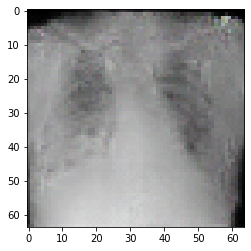

In [77]:
from matplotlib import pyplot as plt
plt.imshow(gen_samples[220])
plt.show()

In [ ]:
def show_images(n_row, n_col, images, epoch=5):
  from matplotlib import pyplot as plt
  class_names=["normal","lung_opacity"]
  fig, ax = plt.subplots(n_row, n_col, figsize=(16, 16))
  fig.subplots_adjust(hspace=-0.80, wspace=0.1)
  for i in range(n_row):
      for j in range(n_col):
          ax[i, j].get_xaxis().set_visible(False)
          ax[i, j].get_yaxis().set_visible(False)
          ax[i, j].imshow(images[i][j])
          ax[i, j].title.set_text( "fake: \n {}".format(class_names[i]) )
  #fig.savefig('bagan_gp_results/generated_plot_%d.png' % epoch)

In [ ]:
show_images(2, 10, gen_samples[0:10])

In [76]:
len(gen_samples), type(gen_samples[0])

(1000, numpy.ndarray)

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
i = 0
for image in gen_samples:
  plt.imsave("synthetic/covid_small/covid_small_{}.jpg".format(i), image)
  i = i + 1

In [ ]:
import numpy as np
np.save("synthetic/covid_small.npy", gen_samples)

In [ ]:
x = np.load("synthetic/covid_small.npy")
x.shape

(250, 64, 64, 3)

# Divide set to train by percentage (1%, 10% ... )

In [ ]:
import numpy as np
x_train = np.load('x_train.npy')
x_val = np.load('x_val.npy')
y_train = np.load('y_train.npy')

In [ ]:
total = x_train.shape[0]
samples = int(total*0.01)
samples, type(samples)

(10, int)

In [ ]:
train_by_percentage = x_train[0:samples]
train_by_percentage.shape

(10, 64, 64, 3)

In [ ]:
def divide_set_by_percentage(percentage, x_train, y_train):
  total_samples = x_train.shape[0]
  new_samples = int(total*percentage)
  return x_train[0:new_samples], y_train[0:new_samples]


In [ ]:
a, b = divide_set_by_percentage(0.01, x_train, y_train)
a.shape, b.shape
a, b = divide_set_by_percentage(0.1, x_train, y_train)
a.shape, b.shape

((101, 64, 64, 3), (101,))

In [ ]:
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220413_232637-36h9ipqe
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run expert-lake-30
wandb: ⭐️ View project at https://wandb.ai/jgim/xray_improved_bagan_v2.0
wandb: 🚀 View run at https://wandb.ai/jgim/xray_improved_bagan_v2.0/runs/36h9ipqe
Xray dataset ====
images.shape: (1017, 64, 64, 3)
labels.shape: (1017,)
Reduced size images.shape: (101, 64, 64, 3)
Reduced size labels.shape: (101,)
Get number of classes: 3
set channel: 3
x_train.shape: (90, 64, 64, 3)
y_train.shape: (90,)
x_test.shape: (11, 64, 64, 3)
y_test.shape: (11,)
Again: check the number of classes: 3
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
202

In [ ]:
!python fid_score.py

2022-04-13 23:29:01.494443: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
87924736/87910968 [==============================] - 0s 0us/step
real_imgs.shape: (113, 64, 64, 3)
class: covid_19
Latent dimension: 128
Scaled (1000, 299, 299, 3) (13, 299, 299, 3)
Scaled range for generated 91.53891 147.11441
Scaled range for real 0.0 255.0
Scaled range for generated -0.28204775 0.15383852
Scaled range for real -1.0 1.0
2022-04-13 23:29:15.518471: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID(0): 455.719
--------------------------------------------------
class: no_findings
Latent dimension: 128
Scaled (1000, 299, 299, 3) (50, 299, 299, 3)
Scaled range for generated 91.28928 144.31754
Scaled range for real 0.0 220.5
Scaled range for generated -0.28400564 0.13190222
Scaled range for

In [ ]:
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220413_233321-de60p0s8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hopeful-shape-31
wandb: ⭐️ View project at https://wandb.ai/jgim/xray_improved_bagan_v2.0
wandb: 🚀 View run at https://wandb.ai/jgim/xray_improved_bagan_v2.0/runs/de60p0s8
Xray dataset ====
images.shape: (1017, 64, 64, 3)
labels.shape: (1017,)
Reduced size images.shape: (10, 64, 64, 3)
Reduced size labels.shape: (10,)
Get number of classes: 3
set channel: 3
x_train.shape: (9, 64, 64, 3)
y_train.shape: (9,)
x_test.shape: (1, 64, 64, 3)
y_test.shape: (1,)
Again: check the number of classes: 3
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04

In [ ]:
!python fid_score.py

2022-04-13 23:36:17.709823: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (113, 64, 64, 3)
Latent dimension: 128
Scaled (1000, 299, 299, 3) (113, 299, 299, 3)
Scaled range for generated 84.51299 132.54976
Scaled range for real 0.0 235.5
Scaled range for generated -0.33715302 0.039605975
Scaled range for real -1.0 0.8470588
2022-04-13 23:36:31.463436: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID total: 442.518
--------------------------------------------------
class: covid_19
Latent dimension: 128
Scaled (1000, 299, 299, 3) (13, 299, 299, 3)
Scaled range for generated 80.62196 129.96236
Scaled range for real 0.0 255.0
Scaled range for generated -0.3676709 0.01931262
Scaled range for real -1.0 1.0
2022-04-13 23:36:56.920238: W tensorflow/core/framework/cpu

In [ ]:
# 0.5
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220413_234518-26217asx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run solar-darkness-33
wandb: ⭐️ View project at https://wandb.ai/jgim/xray_improved_bagan_v2.0
wandb: 🚀 View run at https://wandb.ai/jgim/xray_improved_bagan_v2.0/runs/26217asx
Xray dataset ====
images.shape: (1017, 64, 64, 3)
labels.shape: (1017,)
Reduced size images.shape: (508, 64, 64, 3)
Reduced size labels.shape: (508,)
Get number of classes: 3
set channel: 3
x_train.shape: (457, 64, 64, 3)
y_train.shape: (457,)
x_test.shape: (51, 64, 64, 3)
y_test.shape: (51,)
Again: check the number of classes: 3
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs

In [ ]:
!python fid_score.py

2022-04-13 23:46:45.416089: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (113, 64, 64, 3)
Latent dimension: 128
Scaled (1000, 299, 299, 3) (113, 299, 299, 3)
Scaled range for generated 5.9707794 230.09027
Scaled range for real 0.0 235.5
Scaled range for generated -0.95317036 0.80462956
Scaled range for real -1.0 0.8470588
2022-04-13 23:46:58.721357: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID total: 299.444
--------------------------------------------------
class: covid_19
Latent dimension: 128
Scaled (1000, 299, 299, 3) (13, 299, 299, 3)
Scaled range for generated 6.2341733 237.96333
Scaled range for real 0.0 255.0
Scaled range for generated -0.9511045 0.86637914
Scaled range for real -1.0 1.0
2022-04-13 23:47:24.787828: W tensorflow/core/framework/cp

# Covid Small dataset

In [ ]:
# 100 epochs was previously trained, we compute FID
!python fid_score.py

2022-04-13 23:59:28.051999: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (113, 64, 64, 3)
Latent dimension: 128
Scaled (1000, 299, 299, 3) (113, 299, 299, 3)
Scaled range for generated 5.3197145e-05 229.57436
Scaled range for real 0.0 235.5
Scaled range for generated -0.9999996 0.80058324
Scaled range for real -1.0 0.8470588
2022-04-13 23:59:40.512845: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID total: 250.667
--------------------------------------------------


In [ ]:
# Train with 200 steps
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220414_000329-a6x1z2bv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wise-brook-35
wandb: ⭐️ View project at https://wandb.ai/jgim/xray_improved_bagan_v2.0
wandb: 🚀 View run at https://wandb.ai/jgim/xray_improved_bagan_v2.0/runs/a6x1z2bv
Xray dataset ====
images.shape: (1017, 64, 64, 3)
labels.shape: (1017,)
Get number of classes: 3
set channel: 3
x_train.shape: (915, 64, 64, 3)
y_train.shape: (915,)
x_test.shape: (102, 64, 64, 3)
y_test.shape: (102,)
Again: check the number of classes: 3
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-14 00:03:33.572981: W tensorflow/core/common_runtime/gpu/gpu_bfc_alloc

In [ ]:
# FID 200
!python fid_score.py

2022-04-14 00:47:50.813607: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (113, 64, 64, 3)
Latent dimension: 128
Scaled (1000, 299, 299, 3) (113, 299, 299, 3)
Scaled range for generated 0.41227788 220.41736
Scaled range for real 0.0 235.5
Scaled range for generated -0.99676645 0.7287636
Scaled range for real -1.0 0.8470588
2022-04-14 00:48:05.353604: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID total: 223.870
--------------------------------------------------


# RSNA data handling and preprocessing

In [ ]:
!pip install -qq pydicom

     |████████████████████████████████| 2.0 MB 25.9 MB/s 


In [ ]:
import pandas as pd

# Labels
labels = pd.read_csv("rsna/stage_2_train_labels.csv")
labels = labels.drop_duplicates("patientId")
print("total labels.shape:",labels.shape)

# Use a specific segment of the dataset
percentage = 300
n_selection = labels.shape[0]//percentage
selected_labels = labels[0:n_selection]
print("selected_labels.shape:",selected_labels.shape)
targets = [ selected_labels[selected_labels["Target"] == 0],
            selected_labels[selected_labels["Target"] == 1] ] 

total labels.shape: (26684, 6)
selected_labels.shape: (88, 6)


(1024, 1024)


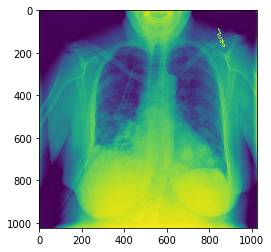

In [ ]:
# Images testing
import pydicom
import pathlib
images_path = pathlib.Path("rsna/stage_2_train_images")
patientIds = list(selected_labels["patientId"])
for i, patientId in enumerate(patientIds):
  if i == 0:
    dcm_path = images_path / patientId
    dcm_path = dcm_path.with_suffix(".dcm")
    ds = pydicom.dcmread(dcm_path)
    print(ds.pixel_array.shape)
    from matplotlib import pyplot as plt
    plt.imshow(ds.pixel_array, interpolation='nearest')
    plt.show()
  break

In [ ]:
"""
Algorithm
Class A and B
1. Create Folder A and Folder B /dataset/A, /dataset/B
2. Move images_A to Folder A, Move images_B to Folder B
3. Apply "image_dataset_from_directory" on the root directory /dataset
"""
import os, shutil, pathlib
import pandas as pd
original_dir = pathlib.Path("rsna/stage_2_train_images")
new_base_dir = pathlib.Path("rsna/datasets/rsna_medium") # change this

def use_subset_of_data(percentage=0.1, 
                       labels_csv_file="rsna/stage_2_train_labels.csv",
                       original_dir=original_dir,
                       new_base_dir=new_base_dir):
  # Labels are segmented by patientId
  # Duplicates are discarded
  labels = pd.read_csv(labels_csv_file)
  labels = labels.drop_duplicates("patientId")
  unique_labels = labels.shape[0]
  print("Total unique images {}.".format(unique_labels))

  # Select only a subset of the whole dataset
  n_selection = int(labels.shape[0]*percentage)
  selected_labels = labels[0:n_selection]
  print("Total selected images {}.".format(selected_labels.shape[0]))

  targets = [ selected_labels[selected_labels["Target"] == 0],
              selected_labels[selected_labels["Target"] == 1] ]

  print("Images with label 0: {}".format(len(targets[0])))
  print("Images with label 1: {}".format(len(targets[1])))
  return targets

def make_subset(subset_name, percentage):
  targets = use_subset_of_data(percentage=percentage)
  print("Creating subset ...")
  for category in ("0", "1"):
    dir = new_base_dir / subset_name / category
    try: 
      os.makedirs(dir)
    except:
      print("directory exists")
    fnames = list( targets[int(category)]["patientId"] )
    for fname in fnames:
      fname = str(fname)+".dcm"
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)
    print("Images copied for target {}: {}.".format(category, len(fnames)))

In [ ]:
make_subset("train", 0.5)

Total unique images 26684.
Total selected images 13342.
Images with label 0: 10398
Images with label 1: 2944
Creating subset ...
Images copied for target 0: 10398.
Images copied for target 1: 2944.


In [ ]:
%pwd

'/content/drive/MyDrive/Improved_BAGAN'

In [ ]:
# Transform dcm files to images
def convert_dcm_to_images(path_to_folder):
  import os, pydicom
  from PIL import Image
  print("Converting dcm files to images ...")
  for filename in os.listdir(path_to_folder):
    if filename.endswith(".dcm"):
      # Path to file name
      fname = pathlib.Path(filename)
      fname = path_to_folder / fname
      # Convert image
      new_name = path_to_folder+"/"+filename[:-4]+".jpg"
      ds = pydicom.dcmread(fname)
      im = Image.fromarray(ds.pixel_array)
      im.save(new_name)
      os.remove(fname)
  print("Done.")

In [ ]:
lung_opacity_dir = "/content/drive/My Drive/Improved_BAGAN/rsna/datasets/rsna_medium/train/lung_opacity"
normal_dir = "/content/drive/My Drive/Improved_BAGAN/rsna/datasets/rsna_medium/train/normal"
convert_dcm_to_images(lung_opacity_dir)
convert_dcm_to_images(normal_dir)

Converting dcm files to images ...
Done.
Converting dcm files to images ...
Done.


In [ ]:
def convert_images_to_numpy(path_to_dataset, class_labels=["normal","lung_opacity"]):
  from sklearn.model_selection import train_test_split
  from tensorflow.keras.utils import image_dataset_from_directory
  SEED = 42
  import pathlib
  import numpy as np
  
  base_dir = pathlib.Path(path_to_dataset)
  total_set = image_dataset_from_directory(
    base_dir / "train",
    image_size=(64,64),
    batch_size=None,
    label_mode="int",
    labels="inferred",
    class_names=class_labels
  )

  print("Splitting images ...")
  x_train = np.array([list(x[0].numpy()) for x in list(total_set)])
  y_train = np.array([x[1].numpy() for x in list(total_set)])
  
  assert( x_train.shape == (13342, 64, 64, 3))
  assert( y_train.shape == (13342, ))
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  random_state=SEED,
                                                  test_size=0.1,
                                                  stratify=y_train)
  print("Images in x_train {}, x_val {}, y_train {}, y_val {}.".format(x_train.shape[0],
                                            x_val.shape[0], y_train.shape[0], y_val.shape[0]))
  # Store as npy files
  np.save("x_train_rsna_medium.npy", x_train)
  np.save("y_train_rsna_medium.npy", y_train)
  np.save("x_val_rsna_medium.npy", x_val)
  np.save("y_val_rsna_medium.npy", y_val)
  return  x_train, x_val, y_train, y_val

In [ ]:
convert_images_to_numpy("/content/drive/My Drive/Improved_BAGAN/rsna/datasets/rsna_medium")

# RSNA small experiments

In [ ]:
# Experiment 1
# Dataset: RSNA
# Train Steps 50
# RSNA_10_perc_samples_50_steps
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220417_012711-2b9umcv8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lemon-wood-2
wandb: ⭐️ View project at https://wandb.ai/jgim/rsna_improved_bagan
wandb: 🚀 View run at https://wandb.ai/jgim/rsna_improved_bagan/runs/2b9umcv8
Xray dataset ====
images.shape: (2401, 64, 64, 3)
labels.shape: (2401,)
Get number of classes: 2
set channel: 3
x_train.shape: (2160, 64, 64, 3)
y_train.shape: (2160,)
x_test.shape: (241, 64, 64, 3)
y_test.shape: (241,)
Again: check the number of classes: 2
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-17 01:27:16.610208: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:3

In [ ]:
# Experiment 1
# Dataset: RSNA
# Train Steps 50
# Score: FID total: 199.639 (1000 vs 267)
#!python fid_score.py

# Score: FID total: 207.84 (267 vs 267)
!python fid_score.py

2022-04-19 16:08:44.571589: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (267, 64, 64, 3)
Latent dimension: 128
Scaled (267, 299, 299, 3) (267, 299, 299, 3)
Scaled range for generated 0.6407824 212.88385
Scaled range for real 0.0 240.0
Scaled range for generated -0.99497426 0.66967726
Scaled range for real -1.0 0.88235295
>>FID total: 207.844
--------------------------------------------------


In [ ]:
# Experiment 2
# Dataset: RSNA
# Train Steps 100
# RSNA_10_perc_samples_100_steps
!python improved_bagan_gp.py


wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220417_023543-3qjwhx2u
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run misty-dew-3
wandb: ⭐️ View project at https://wandb.ai/jgim/rsna_improved_bagan
wandb: 🚀 View run at https://wandb.ai/jgim/rsna_improved_bagan/runs/3qjwhx2u
Xray dataset ====
images.shape: (2401, 64, 64, 3)
labels.shape: (2401,)
Get number of classes: 2
set channel: 3
x_train.shape: (2160, 64, 64, 3)
y_train.shape: (2160,)
x_test.shape: (241, 64, 64, 3)
y_test.shape: (241,)
Again: check the number of classes: 2
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-17 02:35:48.244267: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39

In [ ]:
# Experiment 2
# Dataset: RSNA
# Train Steps 100
# Score: FID total: 184.256
#!python fid_score.py

# Score: FID total: 194.189 (267 vs 267)
!python fid_score.py

2022-04-19 16:10:49.184424: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (267, 64, 64, 3)
Latent dimension: 128
Scaled (267, 299, 299, 3) (267, 299, 299, 3)
Scaled range for generated 0.0006079674 219.57571
Scaled range for real 0.0 240.0
Scaled range for generated -0.99999523 0.7221625
Scaled range for real -1.0 0.88235295
>>FID total: 194.189
--------------------------------------------------


In [ ]:
# Experiment 3
# Dataset: RSNA
# Train Steps 200
# RSNA_10_perc_samples_200_steps_bagan_gp_results
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220417_031952-1gnbzs9p
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lucky-snowflake-5
wandb: ⭐️ View project at https://wandb.ai/jgim/rsna_improved_bagan
wandb: 🚀 View run at https://wandb.ai/jgim/rsna_improved_bagan/runs/1gnbzs9p
Xray dataset ====
images.shape: (2401, 64, 64, 3)
labels.shape: (2401,)
Get number of classes: 2
set channel: 3
x_train.shape: (2160, 64, 64, 3)
y_train.shape: (2160,)
x_test.shape: (241, 64, 64, 3)
y_test.shape: (241,)
Again: check the number of classes: 2
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-17 03:19:57.473792: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator

In [ ]:
# Experiment 3
# Dataset: RSNA
# Train Steps 200
# Score: FID total: 175.42
#!python fid_score.py

# Score: FID total: 181.425 (267 vs 267)
!python fid_score.py

2022-04-19 16:12:34.199303: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (267, 64, 64, 3)
Latent dimension: 128
Scaled (267, 299, 299, 3) (267, 299, 299, 3)
Scaled range for generated 0.0 239.36342
Scaled range for real 0.0 240.0
Scaled range for generated -1.0 0.8773601
Scaled range for real -1.0 0.88235295
>>FID total: 181.425
--------------------------------------------------


# RSNA medium experiments

In [ ]:
# 15 steps
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220419_162723-2bdyzejs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run azure-rain-14
wandb: ⭐️ View project at https://wandb.ai/jgim/rsna_improved_bagan
wandb: 🚀 View run at https://wandb.ai/jgim/rsna_improved_bagan/runs/2bdyzejs
Xray dataset ====
images.shape: (12007, 64, 64, 3)
labels.shape: (12007,)
Get number of classes: 2
set channel: 3
x_train.shape: (10806, 64, 64, 3)
y_train.shape: (10806,)
x_test.shape: (1201, 64, 64, 3)
y_test.shape: (1201,)
Again: check the number of classes: 2
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-19 16:27:38.874688: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocat

In [ ]:
# 15 steps, FID
!python fid_score.py

2022-04-19 17:07:49.059193: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (1335, 64, 64, 3)
Latent dimension: 128
Scaled (1000, 299, 299, 3) (1000, 299, 299, 3)
Scaled range for generated 0.0004787743 243.58496
Scaled range for real 0.0 247.75
Scaled range for generated -0.99999624 0.91047025
Scaled range for real -1.0 0.9431373
2022-04-19 17:08:08.861447: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
2022-04-19 17:08:16.637879: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID total: 164.323
--------------------------------------------------


In [ ]:
# 30 steps
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/My Drive/Improved_BAGAN/wandb/run-20220418_000321-32htc3rv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run distinctive-bee-11
wandb: ⭐️ View project at https://wandb.ai/jgim/rsna_improved_bagan
wandb: 🚀 View run at https://wandb.ai/jgim/rsna_improved_bagan/runs/32htc3rv
Xray dataset ====
images.shape: (12007, 64, 64, 3)
labels.shape: (12007,)
Get number of classes: 2
set channel: 3
x_train.shape: (10806, 64, 64, 3)
y_train.shape: (10806,)
x_test.shape: (1201, 64, 64, 3)
y_test.shape: (1201,)
Again: check the number of classes: 2
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-18 00:03:36.793378: W tensorflow/core/common_runtime/gpu/gpu_bfc_a

In [ ]:
# 50 epochs
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220419_172223-lp7bjt3d
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eager-sky-18
wandb: ⭐️ View project at https://wandb.ai/jgim/rsna_improved_bagan
wandb: 🚀 View run at https://wandb.ai/jgim/rsna_improved_bagan/runs/lp7bjt3d
Xray dataset ====
images.shape: (12007, 64, 64, 3)
labels.shape: (12007,)
Get number of classes: 2
set channel: 3
x_train.shape: (10806, 64, 64, 3)
y_train.shape: (10806,)
x_test.shape: (1201, 64, 64, 3)
y_test.shape: (1201,)
Again: check the number of classes: 2
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-19 17:22:29.273308: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocato

In [ ]:
# 50 epochs FID
!python fid_score.py

2022-04-19 20:46:17.290017: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (1335, 64, 64, 3)
Latent dimension: 128
Scaled (1000, 299, 299, 3) (1000, 299, 299, 3)
Scaled range for generated 0.1490888 248.59982
Scaled range for real 0.0 247.75
Scaled range for generated -0.9988307 0.9498025
Scaled range for real -1.0 0.9431373
2022-04-19 20:46:36.999099: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
2022-04-19 20:46:44.761767: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID total: 123.377
--------------------------------------------------


In [ ]:
# 100 steps
!python improved_bagan_gp.py

wandb: Currently logged in as: jgim (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/drive/MyDrive/Improved_BAGAN/wandb/run-20220419_032432-3mqj6nra
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cosmic-sponge-12
wandb: ⭐️ View project at https://wandb.ai/jgim/rsna_improved_bagan
wandb: 🚀 View run at https://wandb.ai/jgim/rsna_improved_bagan/runs/3mqj6nra
Xray dataset ====
images.shape: (12007, 64, 64, 3)
labels.shape: (12007,)
Get number of classes: 2
set channel: 3
x_train.shape: (10806, 64, 64, 3)
y_train.shape: (10806,)
x_test.shape: (1201, 64, 64, 3)
y_test.shape: (1201,)
Again: check the number of classes: 2
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-19 03:24:51.008828: W tensorflow/core/common_runtime/gpu/gpu_bfc_allo

In [ ]:
# RSNA_medium_30_iter_bagan_gp_results/my_generator.h5
!python fid_score.py

2022-04-19 15:57:16.976053: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (1335, 64, 64, 3)
Latent dimension: 128
Scaled (1000, 299, 299, 3) (1000, 299, 299, 3)
Scaled range for generated 0.00041797757 224.38629
Scaled range for real 0.0 247.75
Scaled range for generated -0.9999967 0.75989246
Scaled range for real -1.0 0.9431373
2022-04-19 15:57:39.485038: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
2022-04-19 15:57:51.258176: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID total: 140.046
--------------------------------------------------


In [ ]:
# RSNA_medium_50_iter_bagan_gp_results/my_generator.h5
!python fid_score.py

2022-04-19 15:58:50.740651: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Traceback (most recent call last):
  File "fid_score.py", line 62, in <module>
    generator = load_model(gen_path)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/saving/save.py", line 204, in load_model
    raise IOError(f'No file or directory found at {filepath_str}')
OSError: No file or directory found at RSNA_medium_50_iter_bagan_gp_results/my_generator.h5


In [ ]:
# RSNA_medium_100_iter_bagan_gp_results/my_generator.h5
!python fid_score.py

2022-04-19 15:59:47.406594: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
real_imgs.shape: (1335, 64, 64, 3)
Latent dimension: 128
Scaled (1000, 299, 299, 3) (1000, 299, 299, 3)
Scaled range for generated 0.0 241.55977
Scaled range for real 0.0 247.75
Scaled range for generated -1.0 0.89458644
Scaled range for real -1.0 0.9431373
2022-04-19 16:00:07.375584: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
2022-04-19 16:00:19.139552: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
>>FID total: 98.485
--------------------------------------------------


In [ ]:
# 200 steps
!python improved_bagan_gp.py

# Original Improved Bagan performance

In [ ]:
!python original_improved_bagan_gp.py

x_train.shape: (7350, 64, 64, 1)
y_train.shape: (7350,)
x_test.shape: (3150, 64, 64, 1)
y_test.shape: (3150,)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-19 15:02:02.612300: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Epoch 1/30
58/58 [==============================] - 7s 65ms/step - loss: 0.3182 - val_loss: 0.6779
Epoch 2/30
58/58 [==============================] - 3s 54ms/step - loss: 0.1533 - val_loss: 0.6306
Epoch 3/30
58/58 [==============================] - 3s 55ms/step - loss: 0.1281 - val_loss: 0.6003
Epoch 4/30
58/58 [==============================] - 3s 54ms/step - loss: 0.1165 - val_loss: 0.5777
Epoch 5/30
58/58 [==============================] - 3s 55ms/step - loss: 0.1096 - val

# t-SNE embeddings

In [17]:
!python tsne_embeddings.py

Generating tsne plot
Pretrained model VGG16
Dataset covid_small, epochs 100
2022-04-20 16:13:18.800104: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Augmented dataset size: 100 Total dataset size: 1100
Augmented dataset size: 100 Total dataset size: 1200
Augmented dataset size: 100 Total dataset size: 1300
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
Figure saved: covid_100_epochs_bagan_gp_results/_covid_small_100_epochs_VGG16_tsne.png


# Example of run with 30 epochs

In [4]:
!python improved_bagan_gp.py

Xray dataset ====
x_train.shape: (915, 64, 64, 3)
y_train.shape: (915,)
x_test.shape: (102, 64, 64, 3)
y_test.shape: (102,)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-04-21 17:39:09.868813: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Epoch 1/50
8/8 [==============================] - 4s 134ms/step - loss: 0.3621 - val_loss: 0.4018
Epoch 2/50
8/8 [==============================] - 0s 53ms/step - loss: 0.2723 - val_loss: 0.4017
Epoch 3/50
8/8 [==============================] - 0s 54ms/step - loss: 0.2345 - val_loss: 0.4019
Epoch 4/50
8/8 [==============================] - 0s 55ms/step - loss: 0.2093 - val_loss: 0.4023
Epoch 5/50
8/8 [==============================] - 0s 54ms/step - loss: 0.1905 